<a href="https://colab.research.google.com/github/plaban1981/NLP_Transformers/blob/main/Zero_Shot_Text_Classification_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/flairNLP/flair.git
!cd flair && pip install .

Cloning into 'flair'...
remote: Enumerating objects: 24703, done.
remote: Counting objects: 100% (489/489), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 24703 (delta 309), reused 441 (delta 286), pack-reused 24214
Receiving objects: 100% (24703/24703), 81.65 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (17787/17787), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/flair
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done

In [ ]:
!pip install kaggle transformers sentencepiece gensim clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=10a1e99a7e7b38cd5cf8f3cb2b8d649b14b67ffffb237cf4caf959098c3e4150
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


# Setting Up Kaggle API to download the dataset

Please follow the steps below to download and use kaggle data within Google Colab:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Keep the kaggle.json handy before running the following cells

In [ ]:
! rm -f -- "kaggle.json"
from google.colab import files
print("Upload kaggle.json")
files.upload()
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Upload kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d surajkum1198/twitterdata
!unzip twitterdata.zip
!ls

  0% 0.00/190k [00:00<?, ?B/s]
100% 190k/190k [00:00<00:00, 79.1MB/s]
Archive:  twitterdata.zip
  inflating: finalSentimentdata2.csv  
finalSentimentdata2.csv  flair	kaggle.json  sample_data  twitterdata.zip


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import csv
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from cleantext import clean
from sklearn import metrics
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from scipy import spatial
import torch
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from time import time
from nltk.corpus import stopwords
from transformers import pipeline

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


# Data Pre Processing

We need to preprocess the data a bit before we can convert this to a multi-class classification.

Let's look at the data, first

In [ ]:
data = pd.read_csv("finalSentimentdata2.csv").loc[:, ['sentiment', 'text']]
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['sentiment'], random_state=42)
train_data, validation_data = train_test_split(train_data, test_size=0.2, stratify=train_data['sentiment'], random_state=42)
train_data.head()

,sentiment,text
1825,joy,the has made me appreciate the office …
915,joy,great to see the special towing services by to...
1637,anger,what part of ‘social distancing'/‘stay at home...
955,fear,it upsets me that he has coronavirus because i...
639,anger,just waiting for the usual race baiters to tel...


Basic Cleaning and filtering for a select few genres to reduce the complexity of the problem

In [ ]:
train_data.shape, validation_data.shape, test_data.shape

((1977, 2), (495, 2), (618, 2))

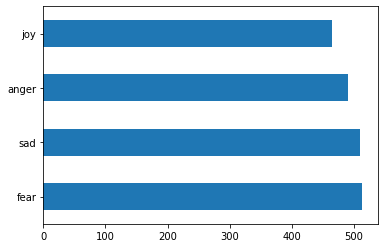

In [ ]:
train_data['sentiment'].value_counts().plot(kind='barh')

Basic Cleaning

In [ ]:
# def clean_text(x):
#     return (x.pipe(hero.fillna)
#                  .pipe(hero.lowercase)
#                  .pipe(hero.remove_digits)
#                 #  .pipe(hero.remove_punctuation)
#                  .pipe(hero.remove_whitespace)
#                  .pipe(hero.remove_urls)
#                  .pipe(hero.remove_round_brackets)
#                  .pipe(hero.remove_square_brackets))

def clean_text(x):
    return clean(x,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_emails=True,                # replace all email addresses with a special token
        no_phone_numbers=True,         # replace all phone numbers with a special token
        no_numbers=True,               # replace all numbers with a special token
        no_digits=True,                # replace all digits with a special token
        no_currency_symbols=True,      # replace all currency symbols with a special token
        no_punct=True,                 # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="en"                       # set to 'de' for German special handling
    )


In [ ]:
train_data["text"] = train_data["text"].apply(clean_text)
validation_data["text"] = validation_data["text"].apply(clean_text)
test_data["text"] = test_data["text"].apply(clean_text)
labels = test_data["sentiment"].unique().tolist()

# Word Clouds

In [ ]:
from wordcloud import WordCloud,STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS.update(["one"])
w = stopwords.words('english')
STOPWORDS.update(w)
STOPWORDS.update(["corona","covid", "coronavirus", "virus"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from PIL import Image
import requests
def make_plot_words(emotion):
    des = " ".join(plot for plot in train_data[train_data["sentiment"]==emotion].text)
    url = "https://image.similarpng.com/very-thumbnail/2020/07/Twitter-new-logo-on-transparent-background-PNG-.png"
    mask = np.array(Image.open(requests.get(url, stream=True).raw ))
    wordcloud = WordCloud(width=1600, height=800, mask=mask, mode="RGBA", background_color='white', max_words=1000).generate(des)
    plt.figure(figsize=(15,10))
    #plt.gcf().set_facecolor("black")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(label=" Word Cloud for {}".format(emotion), fontsize=40)
    plt.tight_layout(pad=0)
    #plt.savefig("./{}.png".format(genre), format="png")
    plt.show()

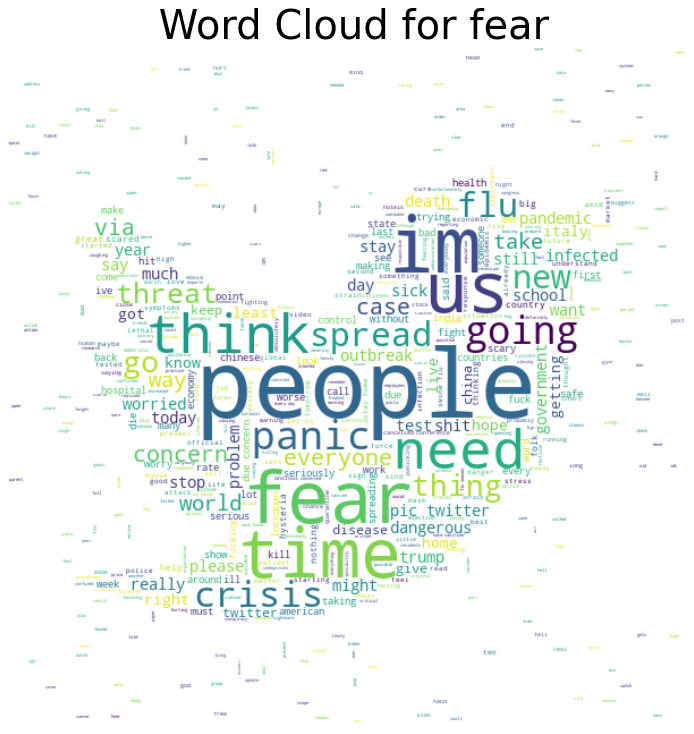

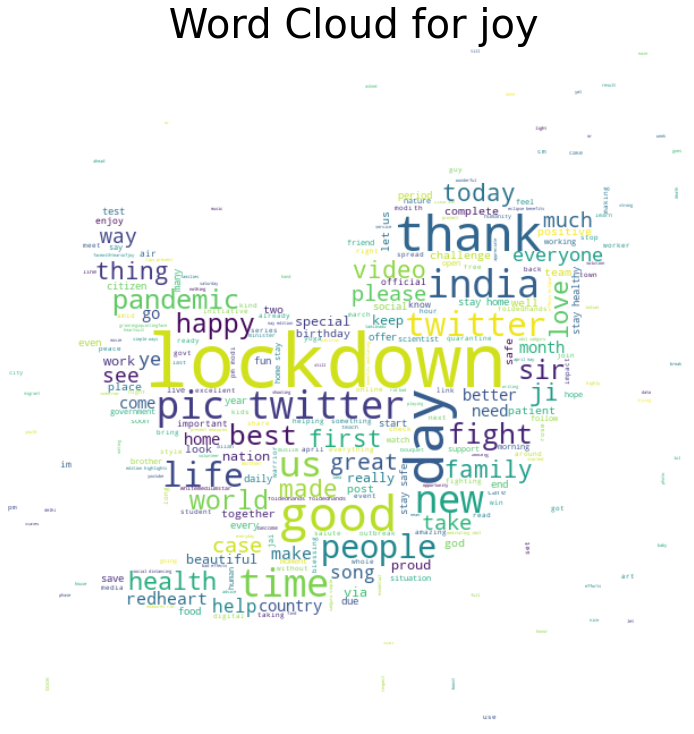

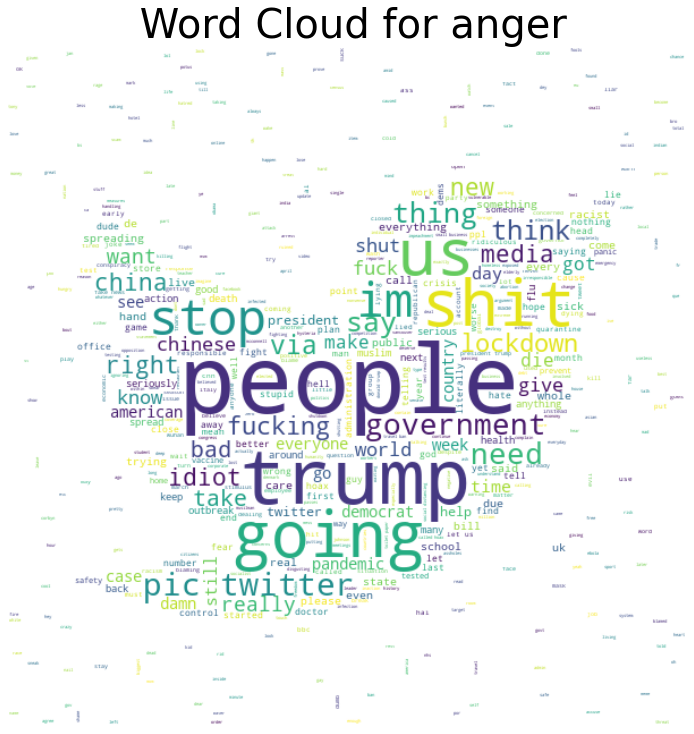

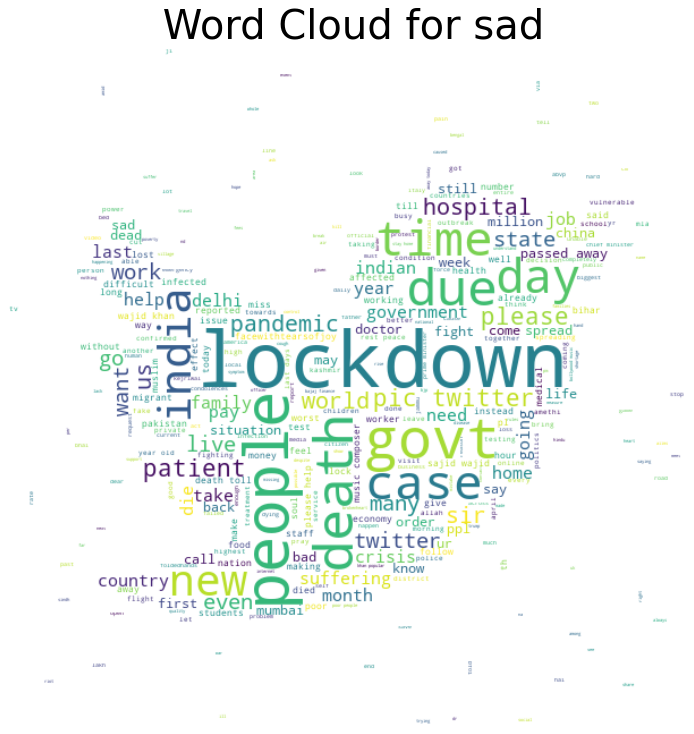

In [ ]:
for i, g in enumerate(labels):
    make_plot_words(emotion=g)

# Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create encoder based on train data
labelEncoder = LabelEncoder()
labelEncoder.fit(train_data.sentiment)

# Train data
train_x = train_data.text.values
train_y = labelEncoder.transform(train_data.sentiment)
 
       
# Validation data
validation_x = validation_data.text.values
validation_y = labelEncoder.transform(validation_data.sentiment)

# Test data
test_x = test_data.text.values
test_y = labelEncoder.transform(test_data.sentiment)

labels = labelEncoder.classes_

In [ ]:
def classification_report(y, pred, target):
    acc = metrics.accuracy_score(y, pred)*100
    f1 = metrics.f1_score(y, pred, average="macro")*100
    print(f'''##########################################\n#\tTest accuracy is {acc:.4f}%\t#\n#\tTest f1 is {f1:.4f}%\t#\n##########################################''')
    print("------------------------------------------------------------")
    print(metrics.classification_report(y, pred, target_names=target))
    cm = metrics.confusion_matrix(y, pred)
    plt.figure(figsize = (15,10))
    sns.heatmap(cm,annot=True, fmt=".1f", xticklabels=target, yticklabels=target)
    plt.xlabel('Predicted')
    plt.show()
    return acc, f1

# Defining custom function which returns
# the list for df.style.apply() method
def highlight_max(s):
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['font-weight: bold; color: green' if cell else '' for cell in is_max]

# Baseline Supervised Classification

In [ ]:
benchmarks = []

## Training Linear SVC

In [ ]:
stop_words = set(stopwords.words('english'))

t0 = time()
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))),
                ('clf', LinearSVC()),
            ])
SVC_pipeline.fit(train_x, train_y)
runtime = (time() - t0)/60
print("Training took: {:.3f}[seconds] to complete".format(runtime))
print('Train F1 Score : %.3f'%metrics.f1_score(SVC_pipeline.predict(train_x), train_y, average="macro"))
print('Test F1 Score : %.3f'%metrics.f1_score(SVC_pipeline.predict(test_x), test_y, average="macro"))

Training took: 0.008[seconds] to complete
Train F1 Score : 1.000
Test F1 Score : 0.666


## Test Performance

##########################################
#	Test accuracy is 66.8285%	#
#	Test f1 is 66.6323%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.62      0.51      0.56       154
        fear       0.60      0.62      0.61       160
         joy       0.79      0.73      0.76       145
         sad       0.68      0.81      0.74       159

    accuracy                           0.67       618
   macro avg       0.67      0.67      0.67       618
weighted avg       0.67      0.67      0.67       618



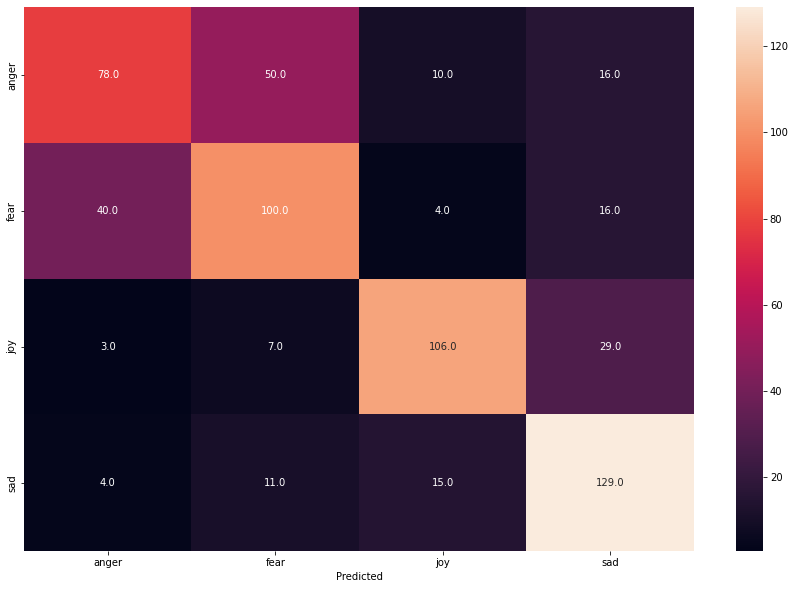

In [ ]:
pred_svc = SVC_pipeline.predict(test_x)
acc, f1 = classification_report(test_y, pred_svc, labels)
benchmarks.append({
    "Model": "Baseline Supervised",
    "Prompt": "",
    "Accuracy": acc,
    "F1" : f1
})

# Zero Shot Classification

In [ ]:
def get_device():
    return 0 if torch.cuda.is_available() else -1

## Latent Embedding

In [ ]:
from transformers import pipeline
# Loading the model from huggingface hub
encoder = pipeline("feature-extraction", model="deepset/sentence_bert", device=get_device())

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

**Multi Class**

In [ ]:
sentence = 'Who are you voting for in 2020?'
classes = ['business', 'art & culture', 'politics']
# Mean Pooling across words
sentence_vector = np.array(encoder(sentence)).mean(axis=1)
# Mean Pooling across label words
label_vectors = [np.array(encoder(l)).mean(axis=1) for l in classes]
from scipy import spatial
# Cosine Distance calculation
dist = [spatial.distance.cosine(sentence_vector, lv) for lv in label_vectors]
# Selecting the class with min distance
classes[np.argmin(dist)]

'politics'

## Text-Aware Representation of Sentences (TARS)

TARS is a novel formulation of text classification that addresses these limitations. It imbues the notion of the task at hand into the transformer model itself by factorizing arbitrary classification problems into a generic binary classification problem.

It is implemented in [FlairNLP](https://github.com/flairNLP/flair) and a pretrained model is also available to use.

In [ ]:
from flair.models import TARSClassifier
from flair.data import Sentence

# 1. Load our pre-trained TARS model for English
tars = TARSClassifier.load('tars-base')

2022-07-16 10:46:44,449 https://nlp.informatik.hu-berlin.de/resources/models/tars-base/tars-base-v8.pt not found in cache, downloading to /tmp/tmp43pyo0zs


100%|██████████| 438064585/438064585 [00:22<00:00, 19233195.97B/s]

2022-07-16 10:47:07,803 copying /tmp/tmp43pyo0zs to cache at /root/.flair/models/tars-base-v8.pt


2022-07-16 10:47:09,069 removing temp file /tmp/tmp43pyo0zs
2022-07-16 10:47:09,158 loading file /root/.flair/models/tars-base-v8.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

2022-07-16 10:47:20,720 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model



**Multi Class**

In [ ]:
# 2. Prepare a test sentence
sentence = Sentence("Who are you voting for in 2020?")

# 3. Define some classes that you want to predict using descriptive names
classes = ["politics", "public health", "economics"]

#4. Predict for these classes
tars.predict_zero_shot(sentence, classes, multi_label=False)

# Print sentence with predicted labels
print(sentence)

2022-07-16 01:06:25,928 Provided `None` does not exist in the model. Consider calling `add_and_switch_to_new_task` first.
2022-07-16 01:06:25,929 `ZeroShot` is the current task. Switch to some other task before dropping this.
Sentence: "Who are you voting for in 2020 ?" → politics (0.9892)


**Multi Label**

In [ ]:
# 2. Prepare a test sentence
sentence = Sentence("Who are you voting for in 2020?")

# 3. Define some classes that you want to predict using descriptive names
classes = ["politics", "public health", "economics", "elections"]

#4. Predict for these classes
tars.predict_zero_shot(sentence, classes, multi_label=True)

# Print sentence with predicted labels
sentence.labels

2022-07-16 10:47:42,424 Task `ZeroShot` already exists in TARS model. Switching to it.
2022-07-16 10:47:42,475 `ZeroShot` is the current task. Switch to some other task before dropping this.


['Sentence: "Who are you voting for in 2020 ?"'/'politics' (0.9892),
 'Sentence: "Who are you voting for in 2020 ?"'/'elections' (0.9876)]

## Zero Shot Classification Pipeline from HuggingFace(NLI)

HuggingFace has implemented a zero-shot classification pipeline which travels a slightly different route. It uses Natural Language Inference models to carry out classification by a bit of creative prompt engineering.

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=get_device())

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

**Multi-Class**

In [ ]:
sequence = "Who are you voting for in 2020?"
candidate_labels = ["politics", "public health", "economics"]
# Call the ZS classifier
classifier(sequence, candidate_labels)

{'labels': ['politics', 'economics', 'public health'],
 'scores': [0.9725189208984375, 0.014584096148610115, 0.012897023931145668],
 'sequence': 'Who are you voting for in 2020?'}

**Multi-Label**

In [ ]:
sequence = "Who are you voting for in 2020?"
candidate_labels = ["politics", "public health", "economics", "elections"]
# Call the ZS classifier
classifier(sequence, candidate_labels, multi_class=True)

{'labels': ['politics', 'elections', 'public health', 'economics'],
 'scores': [0.9720695614814758,
  0.9676108956336975,
  0.03248705714941025,
  0.00616439338773489],
 'sequence': 'Who are you voting for in 2020?'}

## Evaluation on Training Examples

In [ ]:
from pprint import pprint
idx =  333#@param {type:"integer"}


In [ ]:
print(f"Actual Sentiment: {train_data.iloc[idx]['sentiment']}")
pprint(train_data.iloc[idx]['text'])

Actual Sentiment: sad
'this is so sad actor andrew jack is another victim of the coronavirus'


In [ ]:
sentence_vector = np.array(encoder(train_x[idx])).mean(axis=1)
label_vectors = [np.array(encoder(l)).mean(axis=1) for l in labels]
dist = [spatial.distance.cosine(sentence_vector, lv) for lv in label_vectors]
labels[np.argmin(dist)]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


'sad'

In [ ]:
tars = TARSClassifier.load('tars-base')
sentence = Sentence(train_x[idx])
tars.predict_zero_shot(sentence, labels, multi_label=False)
print(sentence.labels)

2022-07-16 10:52:39,688 loading file /root/.flair/models/tars-base-v8.pt
2022-07-16 10:52:43,038 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2022-07-16 10:52:43,245 Provided `None` does not exist in the model. Consider calling `add_and_switch_to_new_task` first.
2022-07-16 10:52:43,246 `ZeroShot` is the current task. Switch to some other task before dropping this.
['Sentence: "this is so sad actor andrew jack is another victim of the coronavirus"'/'sad' (0.9927)]


In [ ]:
res = classifier(train_x[idx], candidate_labels=labels, multi_label=False, truncation=True)
# print([f"{l} : {s:.2f}" for l,s in zip(res["labels"], res['scores']) if s>=0.5])
print([f"{l} : {s:.2f}" for l,s in zip(res["labels"], res['scores'])])

['sad : 0.99', 'fear : 0.00', 'anger : 0.00', 'joy : 0.00']


## Evaluation on Test Set

### Latent Embedding

#### Baseline

In [ ]:
pred_l = []
scores_l = []
for x in tqdm(test_x):
    sentence_vector = np.array(encoder(x)).mean(axis=1)
    label_vectors = [np.array(encoder(l)).mean(axis=1) for l in labels]
    dist = [spatial.distance.cosine(sentence_vector, lv) for lv in label_vectors]
    m = np.argmin(dist)
    pred_l.append(labels[m])
    scores_l.append(np.min(dist))


  0%|          | 0/618 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


##########################################
#	Test accuracy is 49.0291%	#
#	Test f1 is 47.5602%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.47      0.22      0.30       154
        fear       0.43      0.56      0.49       160
         joy       0.58      0.72      0.64       145
         sad       0.48      0.47      0.47       159

    accuracy                           0.49       618
   macro avg       0.49      0.49      0.48       618
weighted avg       0.49      0.49      0.47       618



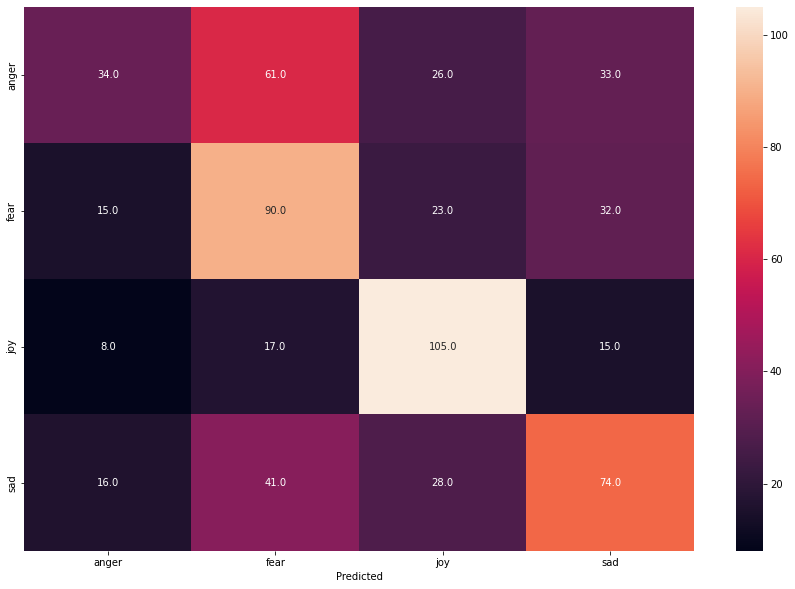

In [ ]:
latent_test_pred = np.array(pred_l)
latent_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(latent_test_pred), labels)
benchmarks.append({
    "Model": "Latent Embedding",
    "Prompt": "",
    "Accuracy": acc,
    "F1" : f1
})

### TARS

#### Baseline

In [ ]:
from flair.data import Dictionary
#Loading the Model
tars = TARSClassifier.load('tars-base')
#Creating a Dictionary of possible labels
label_dictionary = Dictionary(add_unk=False)
for label in labels:
    label_dictionary.add_item(label)
#Creating a new task with the set labels
tars.add_and_switch_to_new_task(
            task_name="ZeroShot",
            label_dictionary=label_dictionary,
            label_type="-".join(label_dictionary.get_items()),
            multi_label=False,
        )
#Creating a list of sentences
sentence_list = []
for x in tqdm(test_x):
    sentence_list.append(Sentence(x))
#Predicting on all sentences
tars.predict(sentence_list,label_threshold=0.0)
# Saving the results into lists
pred_l = []
scores_l = []
for s in sentence_list:
    pred_l.append(s.tag)
    scores_l.append(s.score)

2022-07-16 01:08:15,081 loading file /root/.flair/models/tars-base-v8.pt
2022-07-16 01:08:25,565 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model


  0%|          | 0/618 [00:00<?, ?it/s]

##########################################
#	Test accuracy is 45.3074%	#
#	Test f1 is 45.5076%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.33      0.67      0.44       154
        fear       0.59      0.42      0.49       160
         joy       0.73      0.51      0.60       145
         sad       0.40      0.23      0.29       159

    accuracy                           0.45       618
   macro avg       0.51      0.46      0.46       618
weighted avg       0.51      0.45      0.45       618



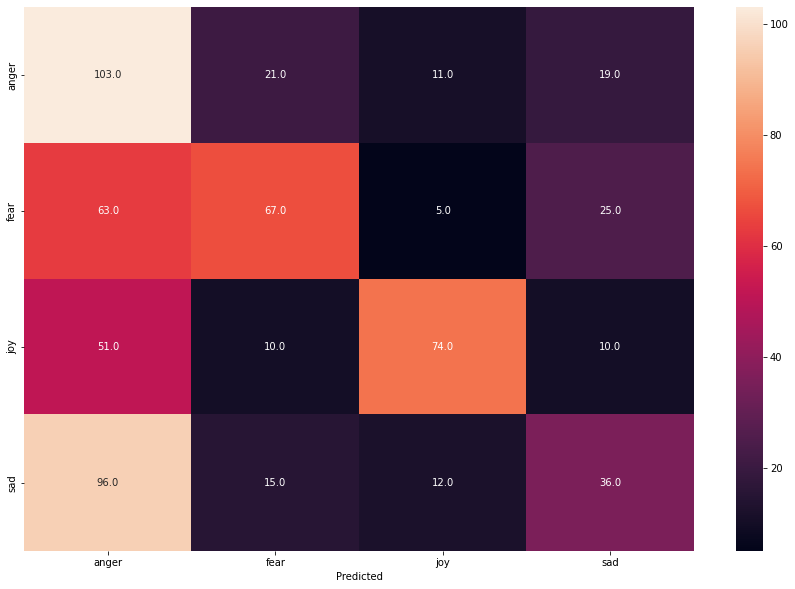

In [ ]:
tars_test_pred = np.array(pred_l)
tars_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(tars_test_pred), labels)
benchmarks.append({
    "Model": "TARS",
    "Prompt": "",
    "Accuracy": acc,
    "F1" : f1
})

### Huggingface(NLI)

#### Baseline

In [ ]:
pred_l = []
scores_l = []
for x in tqdm(test_x):
    res = classifier(x, candidate_labels=labels, multi_label=False, truncation=True)
    pred_l.append(res['labels'][np.argmax(res['scores'])])
    scores_l.append(np.max(res['scores']))


  0%|          | 0/618 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


##########################################
#	Test accuracy is 52.9126%	#
#	Test f1 is 50.7701%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.59      0.16      0.25       154
        fear       0.50      0.62      0.55       160
         joy       0.77      0.63      0.70       145
         sad       0.43      0.70      0.53       159

    accuracy                           0.53       618
   macro avg       0.57      0.53      0.51       618
weighted avg       0.57      0.53      0.51       618



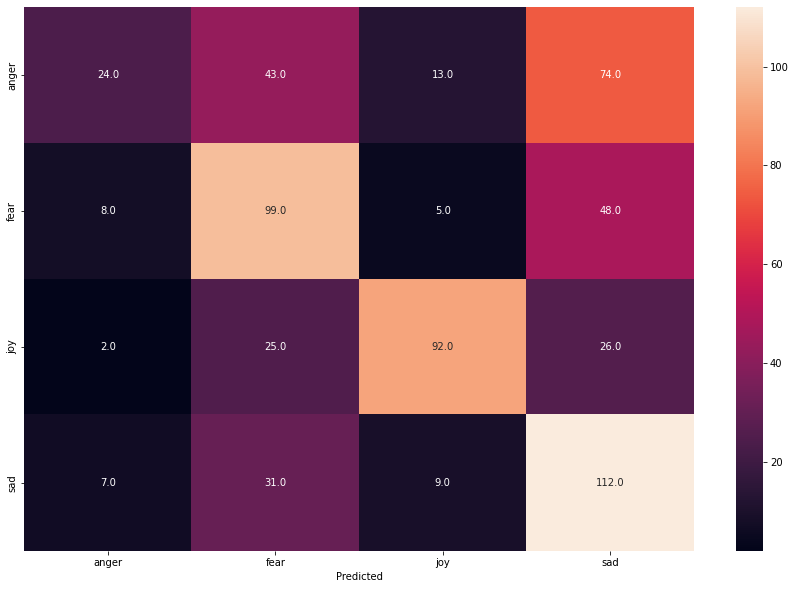

In [ ]:
hg_test_pred = np.array(pred_l)
hg_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(hg_test_pred), labels)
benchmarks.append({
    "Model": "Huggingface (NLI)",
    "Prompt": "This example is {}",
    "Accuracy": acc,
    "F1" : f1
})

## Prompt Engineering

The default prompt to construct the hypothesis is **This example is {label}**. We can change the prompt to better suit the task at hand.

##### Experiments

**Prompt: "The emotion is |label|"**

In [ ]:
pred_l = []
scores_l = []
for x in tqdm(test_x):
    res = classifier(x, candidate_labels=labels, multi_label=False, truncation=True, hypothesis_template="The emotion is {}")
    pred_l.append(res['labels'][np.argmax(res['scores'])])
    scores_l.append(np.max(res['scores']))


  0%|          | 0/618 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


##########################################
#	Test accuracy is 48.8673%	#
#	Test f1 is 49.0882%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.40      0.42      0.41       154
        fear       0.39      0.71      0.51       160
         joy       0.89      0.57      0.69       145
         sad       0.55      0.26      0.36       159

    accuracy                           0.49       618
   macro avg       0.56      0.49      0.49       618
weighted avg       0.55      0.49      0.49       618



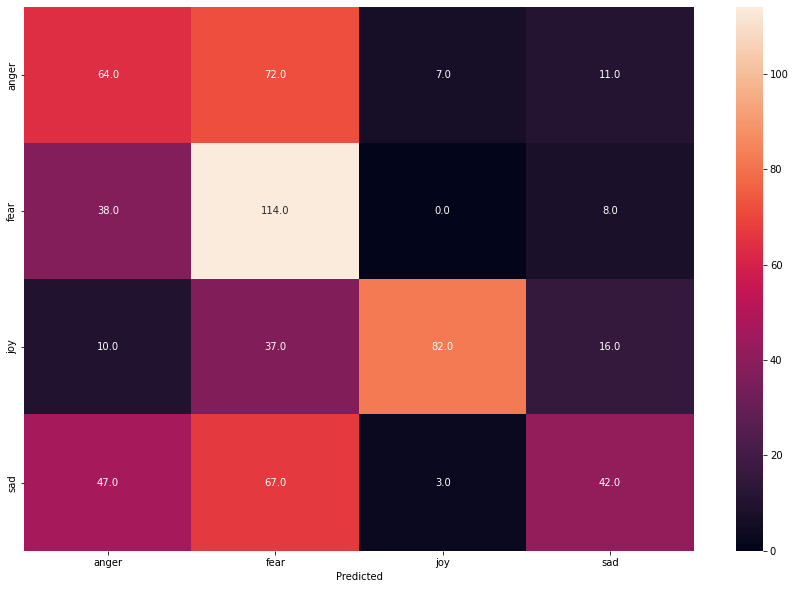

In [ ]:
hg_test_pred = np.array(pred_l)
hg_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(hg_test_pred), labels)
benchmarks.append({
    "Model": "Huggingface (NLI)",
    "Prompt": "The emotion is {}",
    "Accuracy": acc,
    "F1" : f1
})

**Prompt: "The emotion in the text is -label-"**

In [ ]:
pred_l = []
scores_l = []
for x in tqdm(test_x):
    res = classifier(x, candidate_labels=labels, multi_label=False, truncation=True, hypothesis_template="The emotion in the text is {}")
    pred_l.append(res['labels'][np.argmax(res['scores'])])
    scores_l.append(np.max(res['scores']))


  0%|          | 0/618 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


##########################################
#	Test accuracy is 48.7055%	#
#	Test f1 is 49.3026%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.41      0.44      0.43       154
        fear       0.42      0.66      0.51       160
         joy       0.88      0.49      0.63       145
         sad       0.46      0.36      0.40       159

    accuracy                           0.49       618
   macro avg       0.54      0.49      0.49       618
weighted avg       0.54      0.49      0.49       618



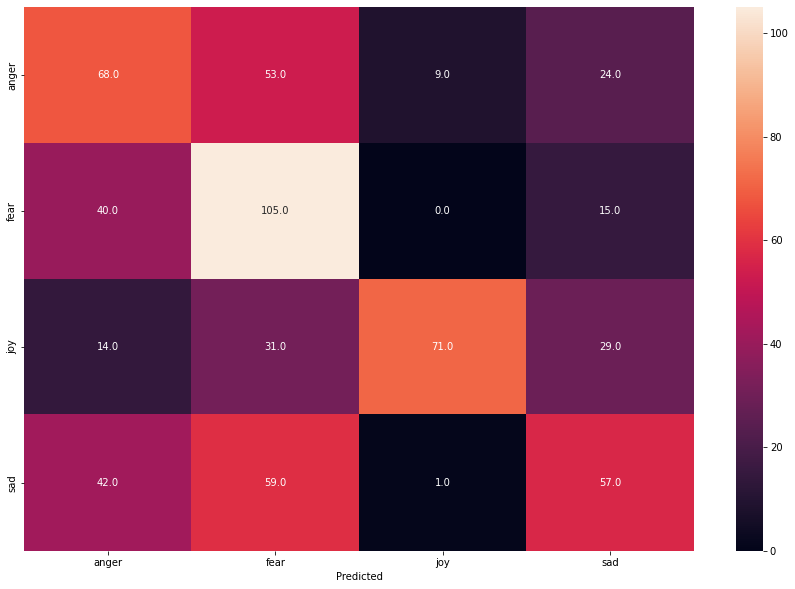

In [ ]:
hg_test_pred = np.array(pred_l)
hg_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(hg_test_pred), labels)
benchmarks.append({
    "Model": "Huggingface (NLI)",
    "Prompt": "The emotion in the text is {}",
    "Accuracy": acc,
    "F1" : f1
})

**Prompt: "The person is feeling |label|"**

In [ ]:
pred_l = []
scores_l = []
for x in tqdm(test_x):
    res = classifier(x, candidate_labels=labels, multi_label=False, truncation=True, hypothesis_template="The person is feeling {}")
    pred_l.append(res['labels'][np.argmax(res['scores'])])
    scores_l.append(np.max(res['scores']))


  0%|          | 0/618 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


##########################################
#	Test accuracy is 48.0583%	#
#	Test f1 is 46.9294%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.44      0.37      0.40       154
        fear       0.38      0.84      0.53       160
         joy       0.88      0.48      0.62       145
         sad       0.65      0.22      0.33       159

    accuracy                           0.48       618
   macro avg       0.59      0.48      0.47       618
weighted avg       0.58      0.48      0.47       618



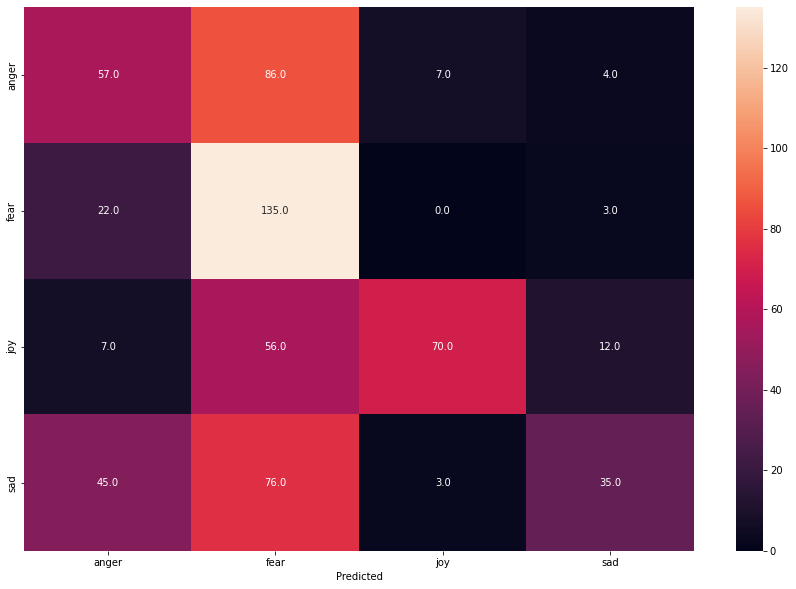

In [ ]:
hg_test_pred = np.array(pred_l)
hg_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(hg_test_pred), labels)
benchmarks.append({
    "Model": "Huggingface (NLI)",
    "Prompt": "The person is feeling {}",
    "Accuracy": acc,
    "F1" : f1
})

##### Summary

In [ ]:
benchmark_df = pd.DataFrame(benchmarks)
# benchmark_df
benchmark_df[benchmark_df.Model=="Huggingface (NLI)"].style.apply(highlight_max)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,Model,Prompt,Accuracy,F1
3,Huggingface (NLI),This example is {},52.912621,50.770059
4,Huggingface (NLI),The emotion is {},48.867314,49.088192
5,Huggingface (NLI),The emotion in the text is {},48.705502,49.302647
6,Huggingface (NLI),The person is feeling {},48.058252,46.929413


#### Domain Adaptation of LM

Using a different model more closer to the domain you are trying to apply also makes a difference. Here we use a model which is trained on yahoo answers, which is closer to the tweet dataset that we are using.

In [ ]:
classifier = pipeline("zero-shot-classification", model="joeddav/bart-large-mnli-yahoo-answers", device=get_device())

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

##### Experiments


**Default Prompt: "This example is |label|"**

In [ ]:
pred_l = []
scores_l = []
for x in tqdm(test_x):
    res = classifier(x, candidate_labels=labels, multi_label=False, truncation=True)
    pred_l.append(res['labels'][np.argmax(res['scores'])])
    scores_l.append(np.max(res['scores']))

  0%|          | 0/618 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


##########################################
#	Test accuracy is 51.9417%	#
#	Test f1 is 50.1810%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.39      0.16      0.22       154
        fear       0.52      0.61      0.56       160
         joy       0.81      0.60      0.69       145
         sad       0.43      0.71      0.54       159

    accuracy                           0.52       618
   macro avg       0.54      0.52      0.50       618
weighted avg       0.53      0.52      0.50       618



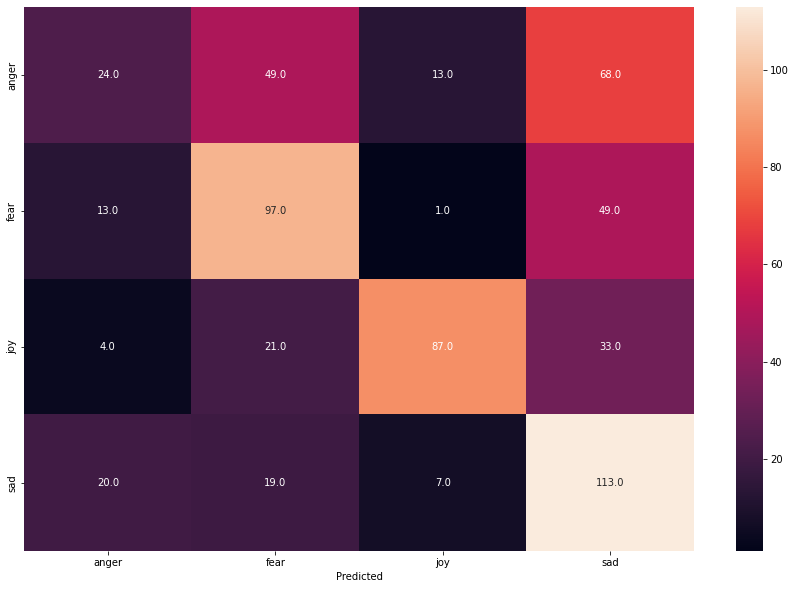

In [ ]:
hg_test_pred = np.array(pred_l)
hg_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(hg_test_pred), labels)
benchmarks.append({
    "Model": "Domain Adapted Huggingface (NLI)",
    "Prompt": "This example is {}",
    "Accuracy": acc,
    "F1" : f1
})

**Default Prompt: "The emotion is |label|"**

In [ ]:
pred_l = []
scores_l = []
for x in tqdm(test_x):
    res = classifier(x, candidate_labels=labels, multi_label=False, truncation=True, hypothesis_template="The emotion is {}")
    pred_l.append(res['labels'][np.argmax(res['scores'])])
    scores_l.append(np.max(res['scores']))


  0%|          | 0/618 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


##########################################
#	Test accuracy is 52.1036%	#
#	Test f1 is 52.1971%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.40      0.47      0.43       154
        fear       0.49      0.69      0.57       160
         joy       0.80      0.60      0.69       145
         sad       0.50      0.33      0.40       159

    accuracy                           0.52       618
   macro avg       0.55      0.52      0.52       618
weighted avg       0.54      0.52      0.52       618



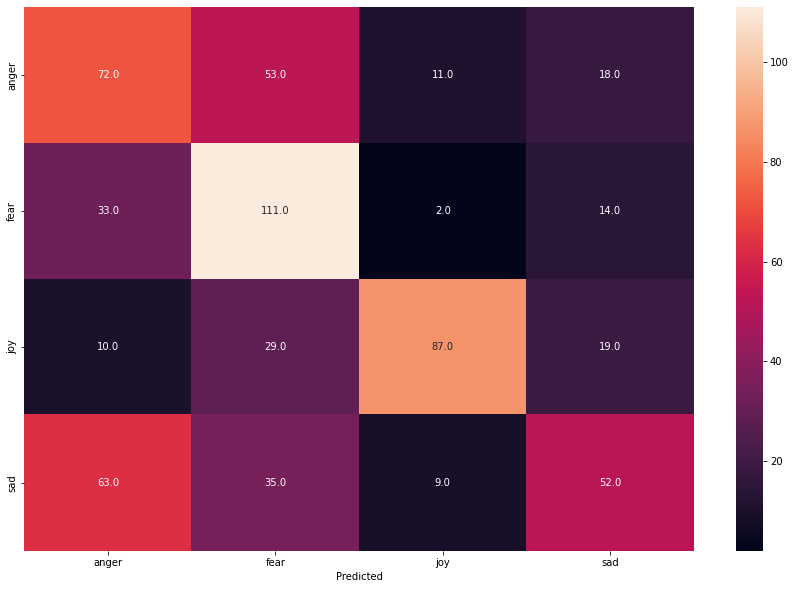

In [ ]:
hg_test_pred = np.array(pred_l)
hg_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(hg_test_pred), labels)
benchmarks.append({
    "Model": "Domain Adapted Huggingface (NLI)",
    "Prompt": "The emotion is {}",
    "Accuracy": acc,
    "F1" : f1
})

**Default Prompt: "The emotion in the text is |label|"**

In [ ]:
pred_l = []
scores_l = []
for x in tqdm(test_x):
    res = classifier(x, candidate_labels=labels, multi_label=False, truncation=True, hypothesis_template="The emotion in the text is {}")
    pred_l.append(res['labels'][np.argmax(res['scores'])])
    scores_l.append(np.max(res['scores']))

  0%|          | 0/618 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


##########################################
#	Test accuracy is 52.4272%	#
#	Test f1 is 52.2496%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.41      0.52      0.46       154
        fear       0.47      0.72      0.57       160
         joy       0.83      0.58      0.68       145
         sad       0.56      0.28      0.38       159

    accuracy                           0.52       618
   macro avg       0.57      0.53      0.52       618
weighted avg       0.57      0.52      0.52       618



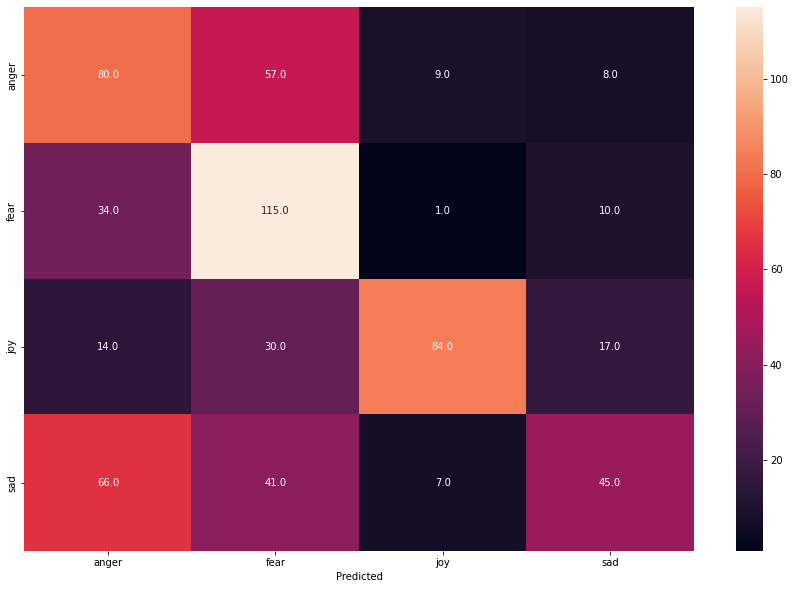

In [ ]:
hg_test_pred = np.array(pred_l)
hg_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(hg_test_pred), labels)
benchmarks.append({
    "Model": "Domain Adapted Huggingface (NLI)",
    "Prompt": "The emotion in the text is {}",
    "Accuracy": acc,
    "F1" : f1
})

**Default Prompt: "The person is feeling |label|"**

In [ ]:
pred_l = []
scores_l = []
for x in tqdm(test_x):
    res = classifier(x, candidate_labels=labels, multi_label=False, truncation=True, hypothesis_template="The person is feeling {}")
    pred_l.append(res['labels'][np.argmax(res['scores'])])
    scores_l.append(np.max(res['scores']))


  0%|          | 0/618 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


##########################################
#	Test accuracy is 50.1618%	#
#	Test f1 is 48.7337%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.40      0.45      0.43       154
        fear       0.41      0.76      0.54       160
         joy       0.80      0.63      0.70       145
         sad       0.76      0.18      0.29       159

    accuracy                           0.50       618
   macro avg       0.59      0.50      0.49       618
weighted avg       0.59      0.50      0.48       618



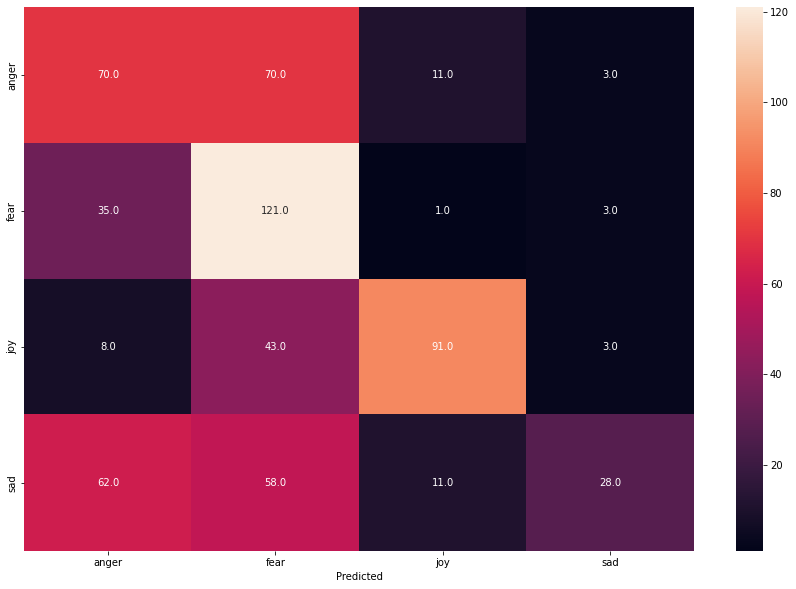

In [ ]:
hg_test_pred = np.array(pred_l)
hg_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(hg_test_pred), labels)
benchmarks.append({
    "Model": "Domain Adapted Huggingface (NLI)",
    "Prompt": "The person is feeling {}",
    "Accuracy": acc,
    "F1" : f1
})

##### Summary

In [ ]:
benchmark_df = pd.DataFrame(benchmarks)
# benchmark_df
benchmark_df[benchmark_df.Model=="Domain Adapted Huggingface (NLI)"].style.apply(highlight_max)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,Model,Prompt,Accuracy,F1
7,Domain Adapted Huggingface (NLI),This example is {},51.941748,50.181038
8,Domain Adapted Huggingface (NLI),The emotion is {},52.103560,52.197146
9,Domain Adapted Huggingface (NLI),The emotion in the text is {},52.427184,52.249640
10,Domain Adapted Huggingface (NLI),The person is feeling {},50.161812,48.733678


# Zero Shot Summary

In [ ]:
benchmark_df = pd.DataFrame(benchmarks)
# benchmark_df
benchmark_df.style.apply(highlight_max)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,Model,Prompt,Accuracy,F1
0,Baseline Supervised,,66.828479,66.632344
1,Latent Embedding,,49.029126,47.560241
2,TARS,,45.307443,45.507572
3,Huggingface (NLI),This example is {},52.912621,50.770059
4,Huggingface (NLI),The emotion is {},48.867314,49.088192
5,Huggingface (NLI),The emotion in the text is {},48.705502,49.302647
6,Huggingface (NLI),The person is feeling {},48.058252,46.929413
7,Domain Adapted Huggingface (NLI),This example is {},51.941748,50.181038
8,Domain Adapted Huggingface (NLI),The emotion is {},52.103560,52.197146
9,Domain Adapted Huggingface (NLI),The emotion in the text is {},52.427184,52.249640


# Bonus: Few Shot Classification

## Splitting Data

We are just taking 50 samples from the validation data to fine tune our models

In [ ]:
min_n = 50
_n_groups =  len(train_data['sentiment'].unique())
_sample_per_grp = math.ceil(min_n/_n_groups )
df = validation_data.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), _sample_per_grp), random_state=33)) #33
df_tr = df
df_tr.shape

(52, 2)

In [ ]:
# Create encoder based on train data
labelEncoder = LabelEncoder()
labelEncoder.fit(df_tr.sentiment)

# Train data
train_x = df_tr.text.values
train_y = labelEncoder.transform(df_tr.sentiment)
        
labels = labelEncoder.classes_

## Baseline

In [ ]:
benchmarks_fewshot = []

In [ ]:
# import nltk
# nltk.download('stopwords')

In [ ]:
stop_words = set(stopwords.words('english'))
t0 = time()
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))),
                ('clf', LinearSVC()),
            ])
SVC_pipeline.fit(train_x, train_y)
runtime = (time() - t0)/60
print("Training took: {:.3f}[seconds] to complete".format(runtime))
print('Train F1 Score : %.3f'%metrics.f1_score(SVC_pipeline.predict(train_x), train_y, average="macro"))
print('Test F1 Score : %.3f'%metrics.f1_score(SVC_pipeline.predict(test_x), test_y, average="macro"))

Training took: 0.000[seconds] to complete
Train F1 Score : 1.000
Test F1 Score : 0.455


##########################################
#	Test accuracy is 46.2783%	#
#	Test f1 is 45.4637%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.43      0.42      0.42       154
        fear       0.44      0.29      0.35       160
         joy       0.47      0.70      0.57       145
         sad       0.50      0.46      0.48       159

    accuracy                           0.46       618
   macro avg       0.46      0.47      0.45       618
weighted avg       0.46      0.46      0.45       618



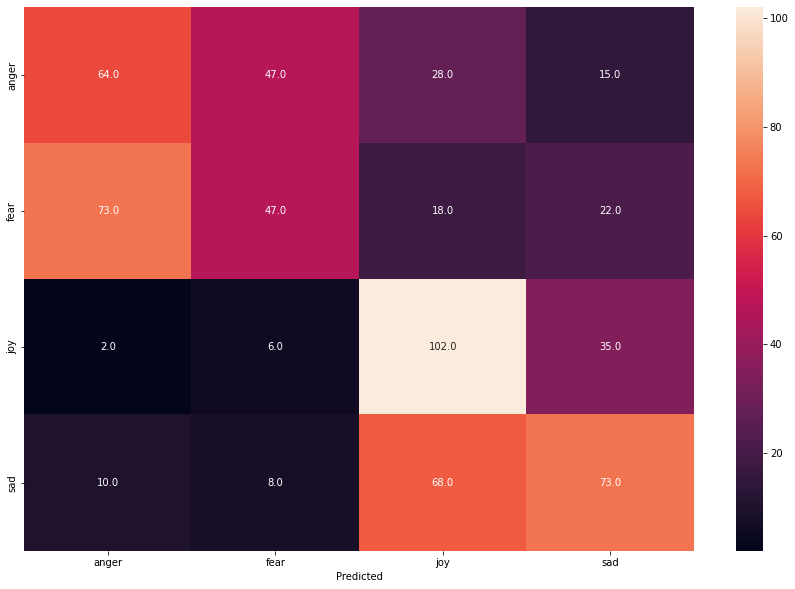

In [ ]:
pred_svc = SVC_pipeline.predict(test_x)
acc, f1 = classification_report(test_y, pred_svc, labels)
benchmarks_fewshot.append({
    "Model": "Baseline Supervised (50 Points)",
    "Accuracy": acc,
    "F1" : f1
})

## Fine Tune BERT

In [ ]:
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
X = tokenizer(train_x.tolist(), padding=True, truncation=True, max_length=512)
X_test = tokenizer(test_x.tolist(), padding=True, truncation=True, max_length=512)
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X, train_y.tolist())

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=8,
    num_train_epochs=20,
    learning_rate=5e-5,
    seed=0,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
)

# Train pre-trained model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 52
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 140


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 16.3879, 'train_samples_per_second': 63.462, 'train_steps_per_second': 8.543, 'train_loss': 0.44988207135881697, 'epoch': 20.0}


TrainOutput(global_step=140, training_loss=0.44988207135881697, metrics={'train_runtime': 16.3879, 'train_samples_per_second': 63.462, 'train_steps_per_second': 8.543, 'train_loss': 0.44988207135881697, 'epoch': 20.0})

In [ ]:
# Create torch dataset
test_dataset = Dataset(X_test)
# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 618
  Batch size = 8


##########################################
#	Test accuracy is 45.6311%	#
#	Test f1 is 45.9223%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.34      0.42      0.37       154
        fear       0.37      0.33      0.35       160
         joy       0.55      0.65      0.59       145
         sad       0.62      0.45      0.52       159

    accuracy                           0.46       618
   macro avg       0.47      0.46      0.46       618
weighted avg       0.47      0.46      0.46       618



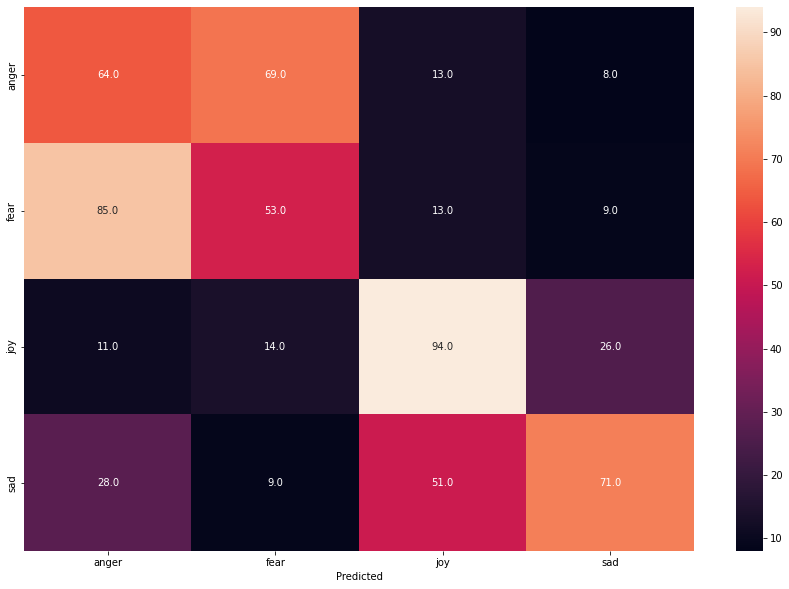

In [ ]:
acc, f1 = classification_report(test_y, y_pred, labels)
benchmarks_fewshot.append({
    "Model": "Fine-Tuned BERT",
    "Accuracy": acc,
    "F1" : f1
})

## TARS - Few Shot Tuned

In [ ]:
from flair.data import Corpus
from flair.datasets import FlairDatapointDataset
from flair.models import TARSClassifier
from flair.data import Sentence

In [ ]:
train = FlairDatapointDataset(
    [Sentence(row['text']).add_label('emotion', row['sentiment']) 
    for idx, row in df_tr.sample(frac=1).iterrows()]
    )

# test dataset consisting of two sentences (1 labeled as "food" and 1 labeled as "drink")
test = FlairDatapointDataset(
    [Sentence(row['text']).add_label('emotion', row['sentiment']) 
    for idx, row in test_data.iterrows()]
    )

# make a corpus with train and test split
corpus = Corpus(train=train, test=test)

# make a label dictionary
label_dict = corpus.make_label_dictionary("emotion")

2022-07-16 01:28:22,359 Computing label dictionary. Progress:


47it [00:00, 13245.47it/s]

2022-07-16 01:28:22,375 Dictionary created for label 'emotion' with 5 values: joy (seen 12 times), anger (seen 12 times), sad (seen 12 times), fear (seen 11 times)


In [ ]:
from flair.trainers import ModelTrainer

# 1. load base TARS
tars = TARSClassifier.load('tars-base')

# 2. make the model aware of the desired set of labels from the new corpus
tars.add_and_switch_to_new_task("EMOTION", label_dictionary=label_dict, label_type="emotion")

# 3. initialize the text classifier trainer with your corpus
trainer = ModelTrainer(tars, corpus)

# 4. train model
trainer.train(base_path='trained_model/emotion', # path to store the model artifacts
              learning_rate=5e-2, # use very small learning rate
              mini_batch_size=1, # small mini-batch size since corpus is tiny
              max_epochs=20, # terminate after 10 epochs
              train_with_dev=False,
              )

2022-07-16 01:28:38,791 loading file /root/.flair/models/tars-base-v8.pt


Model config BertConfig {
  "_name_or_path": "None",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "return_dict": false,
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



2022-07-16 01:28:49,070 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2022-07-16 01:28:49,249 ----------------------------------------------------------------------------------------------------
2022-07-16 01:28:49,252 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (decoder): Linear(in_features=768, out_features=2, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (locked_dropout): LockedDropout(p=0.0)
    (word_dropout): WordDropout(p=0.0)
    (loss_function): CrossEntropyLoss()
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )

100%|██████████| 5/5 [00:00<00:00, 21.85it/s]

2022-07-16 01:28:52,028 Evaluating as a multi-label problem: False
2022-07-16 01:28:52,042 DEV : loss 0.37963977456092834 - f1-score (micro avg)  0.4444
2022-07-16 01:28:52,046 BAD EPOCHS (no improvement): 0
2022-07-16 01:28:52,049 saving best model


2022-07-16 01:28:53,468 ----------------------------------------------------------------------------------------------------
2022-07-16 01:28:53,670 epoch 2 - iter 4/47 - loss 0.10948747 - samples/sec: 22.24 - lr: 0.050000
2022-07-16 01:28:53,877 epoch 2 - iter 8/47 - loss 0.14078627 - samples/sec: 19.59 - lr: 0.050000
2022-07-16 01:28:54,066 epoch 2 - iter 12/47 - loss 0.14483734 - samples/sec: 21.33 - lr: 0.050000
2022-07-16 01:28:54,243 epoch 2 - iter 16/47 - loss 0.16274170 - samples/sec: 22.81 - lr: 0.050000
2022-07-16 01:28:54,448 epoch 2 - iter 20/47 - loss 0.17143328 - samples/sec: 19.76 - lr: 0.050000
2022-07-16 01:28:54,648 epoch 2 - iter 24/47 - loss 0.19384014 - samples/sec: 20.14 - lr: 0.050000
2022-07-16 01:28:54,861 epoch 2 - iter 28/47 - loss 0.19002542 - samples/sec: 18.99 - lr: 0.050000
2022-07-16 01:28:55,061 epoch 2 - iter 32/47 - loss 0.18987544 - samples/sec: 20.15 - lr: 0.050000
2022-07-16 01:28:55,265 epoch 2 - iter 36/47 - loss 0.18039424 - samples/sec: 19.82 -

100%|██████████| 5/5 [00:00<00:00, 20.36it/s]

2022-07-16 01:28:56,077 Evaluating as a multi-label problem: False
2022-07-16 01:28:56,087 DEV : loss 0.3389119803905487 - f1-score (micro avg)  0.4444
2022-07-16 01:28:56,093 BAD EPOCHS (no improvement): 0
2022-07-16 01:28:56,096 ----------------------------------------------------------------------------------------------------


2022-07-16 01:28:56,317 epoch 3 - iter 4/47 - loss 0.03350606 - samples/sec: 20.29 - lr: 0.050000
2022-07-16 01:28:56,524 epoch 3 - iter 8/47 - loss 0.10201059 - samples/sec: 19.49 - lr: 0.050000
2022-07-16 01:28:56,735 epoch 3 - iter 12/47 - loss 0.12696437 - samples/sec: 19.07 - lr: 0.050000
2022-07-16 01:28:56,943 epoch 3 - iter 16/47 - loss 0.10322395 - samples/sec: 19.45 - lr: 0.050000
2022-07-16 01:28:57,139 epoch 3 - iter 20/47 - loss 0.12910929 - samples/sec: 20.56 - lr: 0.050000
2022-07-16 01:28:57,330 epoch 3 - iter 24/47 - loss 0.12887596 - samples/sec: 21.14 - lr: 0.050000
2022-07-16 01:28:57,515 epoch 3 - iter 28/47 - loss 0.11704948 - samples/sec: 21.85 - lr: 0.050000
2022-07-16 01:28:57,714 epoch 3 - iter 32/47 - loss 0.11262325 - samples/sec: 20.37 - lr: 0.050000
2022-07-16 01:28:57,918 epoch 3 - iter 36/47 - loss 0.10902209 - samples/sec: 19.72 - lr: 0.050000
2022-07-16 01:28:58,108 epoch 3 - iter 40/47 - loss 0.11400681 - samples/sec: 21.44 - lr: 0.050000
2022-07-16 0

100%|██████████| 5/5 [00:00<00:00, 21.80it/s]

2022-07-16 01:28:58,718 Evaluating as a multi-label problem: True
2022-07-16 01:28:58,744 DEV : loss 0.6644349098205566 - f1-score (micro avg)  0.7273
2022-07-16 01:28:58,746 BAD EPOCHS (no improvement): 0
2022-07-16 01:28:58,749 saving best model


2022-07-16 01:29:00,447 ----------------------------------------------------------------------------------------------------
2022-07-16 01:29:00,753 epoch 4 - iter 4/47 - loss 0.13785482 - samples/sec: 14.94 - lr: 0.050000
2022-07-16 01:29:00,949 epoch 4 - iter 8/47 - loss 0.20121000 - samples/sec: 20.73 - lr: 0.050000
2022-07-16 01:29:01,150 epoch 4 - iter 12/47 - loss 0.13564427 - samples/sec: 20.04 - lr: 0.050000
2022-07-16 01:29:01,361 epoch 4 - iter 16/47 - loss 0.11901400 - samples/sec: 19.16 - lr: 0.050000
2022-07-16 01:29:01,565 epoch 4 - iter 20/47 - loss 0.09591666 - samples/sec: 19.81 - lr: 0.050000
2022-07-16 01:29:01,752 epoch 4 - iter 24/47 - loss 0.10414586 - samples/sec: 21.64 - lr: 0.050000
2022-07-16 01:29:01,961 epoch 4 - iter 28/47 - loss 0.08987894 - samples/sec: 19.56 - lr: 0.050000
2022-07-16 01:29:02,158 epoch 4 - iter 32/47 - loss 0.07978339 - samples/sec: 20.60 - lr: 0.050000
2022-07-16 01:29:02,356 epoch 4 - iter 36/47 - loss 0.07113655 - samples/sec: 20.39 -

100%|██████████| 5/5 [00:00<00:00, 20.56it/s]

2022-07-16 01:29:03,177 Evaluating as a multi-label problem: False
2022-07-16 01:29:03,193 DEV : loss 1.358135461807251 - f1-score (micro avg)  0.4444
2022-07-16 01:29:03,195 BAD EPOCHS (no improvement): 1
2022-07-16 01:29:03,197 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:03,412 epoch 5 - iter 4/47 - loss 0.00007240 - samples/sec: 20.94 - lr: 0.050000
2022-07-16 01:29:03,597 epoch 5 - iter 8/47 - loss 0.01963882 - samples/sec: 21.82 - lr: 0.050000
2022-07-16 01:29:03,795 epoch 5 - iter 12/47 - loss 0.05582745 - samples/sec: 20.37 - lr: 0.050000
2022-07-16 01:29:04,009 epoch 5 - iter 16/47 - loss 0.04365649 - samples/sec: 18.87 - lr: 0.050000
2022-07-16 01:29:04,214 epoch 5 - iter 20/47 - loss 0.03512739 - samples/sec: 19.65 - lr: 0.050000
2022-07-16 01:29:04,413 epoch 5 - iter 24/47 - loss 0.02953666 - samples/sec: 20.28 - lr: 0.050000
2022-07-16 01:29:04,620 epoch 5 - iter 28/47 - loss 0.02997205 - samples/sec: 19.85 - lr: 0.050000
2022-07-16 01:29:04,811 epoch 5 - iter 32/47 - loss 0.05122131 - samples/sec: 21.12 - lr: 0.050000
2022-07-16 01:29:05,018 epoch 5 - iter 36/47 - loss 0.04640064 - samples/sec: 19.49 - lr: 0.050000
2022-07-16 01:29:05,216 epoch 5 - iter 40/47 - loss 0.04183554 - samples/sec: 20.35 - lr: 0.050000
2022-07-16 0

100%|██████████| 5/5 [00:00<00:00, 21.88it/s]

2022-07-16 01:29:05,820 Evaluating as a multi-label problem: True
2022-07-16 01:29:05,841 DEV : loss 0.74516361951828 - f1-score (micro avg)  0.6
2022-07-16 01:29:05,843 BAD EPOCHS (no improvement): 2
2022-07-16 01:29:05,846 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:06,072 epoch 6 - iter 4/47 - loss 0.00026984 - samples/sec: 19.72 - lr: 0.050000
2022-07-16 01:29:06,255 epoch 6 - iter 8/47 - loss 0.00021118 - samples/sec: 22.25 - lr: 0.050000
2022-07-16 01:29:06,460 epoch 6 - iter 12/47 - loss 0.00015608 - samples/sec: 19.66 - lr: 0.050000
2022-07-16 01:29:06,658 epoch 6 - iter 16/47 - loss 0.00019961 - samples/sec: 20.42 - lr: 0.050000
2022-07-16 01:29:06,860 epoch 6 - iter 20/47 - loss 0.00022037 - samples/sec: 19.94 - lr: 0.050000
2022-07-16 01:29:07,069 epoch 6 - iter 24/47 - loss 0.00020745 - samples/sec: 19.31 - lr: 0.050000
2022-07-16 01:29:07,259 epoch 6 - iter 28/47 - loss 0.00097311 - samples/sec: 21.24 - lr: 0.050000
2022-07-16 01:29:07,480 epoch 6 - iter 32/47 - loss 0.00088089 - samples/sec: 18.33 - lr: 0.050000
2022-07-16 01:29:07,687 epoch 6 - iter 36/47 - loss 0.00079133 - samples/sec: 19.50 - lr: 0.050000
2022-07-16 01:29:07,887 epoch 6 - iter 40/47 - loss 0.00071745 - samples/sec: 20.17 - lr: 0.050000
2022-07-16 0

100%|██████████| 5/5 [00:00<00:00, 21.83it/s]

2022-07-16 01:29:08,476 Evaluating as a multi-label problem: True
2022-07-16 01:29:08,498 DEV : loss 1.100124716758728 - f1-score (micro avg)  0.5455
2022-07-16 01:29:08,500 BAD EPOCHS (no improvement): 3
2022-07-16 01:29:08,503 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:08,712 epoch 7 - iter 4/47 - loss 0.00025146 - samples/sec: 21.58 - lr: 0.050000
2022-07-16 01:29:08,907 epoch 7 - iter 8/47 - loss 0.00016170 - samples/sec: 20.74 - lr: 0.050000
2022-07-16 01:29:09,120 epoch 7 - iter 12/47 - loss 0.00014259 - samples/sec: 18.94 - lr: 0.050000
2022-07-16 01:29:09,322 epoch 7 - iter 16/47 - loss 0.00025084 - samples/sec: 20.06 - lr: 0.050000
2022-07-16 01:29:09,518 epoch 7 - iter 20/47 - loss 0.00020569 - samples/sec: 20.56 - lr: 0.050000
2022-07-16 01:29:09,720 epoch 7 - iter 24/47 - loss 0.00017822 - samples/sec: 20.03 - lr: 0.050000
2022-07-16 01:29:09,933 epoch 7 - iter 28/47 - loss 0.00016613 - samples/sec: 19.33 - lr: 0.050000
2022-07-16 01:29:10,134 epoch 7 - iter 32/47 - loss 0.00015060 - samples/sec: 20.18 - lr: 0.050000
2022-07-16 01:29:10,343 epoch 7 - iter 36/47 - loss 0.00014015 - samples/sec: 19.37 - lr: 0.050000
2022-07-16 01:29:10,535 epoch 7 - iter 40/47 - loss 0.00140128 - samples/sec: 21.07 - lr: 0.050000
2022-07-16 0

100%|██████████| 5/5 [00:00<00:00, 20.84it/s]

2022-07-16 01:29:11,139 Evaluating as a multi-label problem: False
2022-07-16 01:29:11,153 DEV : loss 1.1951020956039429 - f1-score (micro avg)  0.4
2022-07-16 01:29:11,155 Epoch     7: reducing learning rate of group 0 to 2.5000e-02.
2022-07-16 01:29:11,157 BAD EPOCHS (no improvement): 4
2022-07-16 01:29:11,161 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:11,380 epoch 8 - iter 4/47 - loss 0.00003017 - samples/sec: 20.39 - lr: 0.025000
2022-07-16 01:29:11,590 epoch 8 - iter 8/47 - loss 0.00094922 - samples/sec: 19.17 - lr: 0.025000
2022-07-16 01:29:11,806 epoch 8 - iter 12/47 - loss 0.00064656 - samples/sec: 18.72 - lr: 0.025000
2022-07-16 01:29:11,992 epoch 8 - iter 16/47 - loss 0.01971226 - samples/sec: 21.68 - lr: 0.025000
2022-07-16 01:29:12,189 epoch 8 - iter 20/47 - loss 0.01577758 - samples/sec: 20.57 - lr: 0.025000
2022-07-16 01:29:12,384 epoch 8 - iter 24/47 - loss 0.01315320 - samples/sec: 20.74 - lr: 0.025000
2022-07-16 01:29:12,579 epoch 8 - iter 28/47 - loss 0.01129412 - samples/sec: 20.78 - lr: 0.025000
2022-07-16 01:29:12,789 epoch 8 - iter 32/47 - loss 0.00988957 - samples/sec: 19.23 - lr: 0.025000
2022-07-16 01:29:12,983 epoch 8 - iter 36/47 - loss 0.00879310 - samples/sec: 20.78 - lr: 0.025000
2022-07-16 01:29:13,201 epoch 8 - iter 40/47 - loss 0.00791909 - samples/sec: 18.57 - lr: 0.025000
2022-07-16 0

100%|██████████| 5/5 [00:00<00:00, 21.69it/s]

2022-07-16 01:29:13,786 Evaluating as a multi-label problem: False
2022-07-16 01:29:13,799 DEV : loss 1.3753232955932617 - f1-score (micro avg)  0.4444
2022-07-16 01:29:13,803 BAD EPOCHS (no improvement): 1
2022-07-16 01:29:13,806 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:14,023 epoch 9 - iter 4/47 - loss 0.00007978 - samples/sec: 20.50 - lr: 0.025000
2022-07-16 01:29:14,240 epoch 9 - iter 8/47 - loss 0.00007292 - samples/sec: 18.67 - lr: 0.025000
2022-07-16 01:29:14,448 epoch 9 - iter 12/47 - loss 0.00005881 - samples/sec: 19.43 - lr: 0.025000
2022-07-16 01:29:14,649 epoch 9 - iter 16/47 - loss 0.00004934 - samples/sec: 20.68 - lr: 0.025000
2022-07-16 01:29:14,842 epoch 9 - iter 20/47 - loss 0.00004653 - samples/sec: 20.96 - lr: 0.025000
2022-07-16 01:29:15,042 epoch 9 - iter 24/47 - loss 0.00004556 - samples/sec: 20.17 - lr: 0.025000
2022-07-16 01:29:15,238 epoch 9 - iter 28/47 - loss 0.00005777 - samples/sec: 20.59 - lr: 0.025000
2022-07-16 01:29:15,443 epoch 9 - iter 32/47 - loss 0.00007306 - samples/sec: 19.70 - lr: 0.025000
2022-07-16 01:29:15,637 epoch 9 - iter 36/47 - loss 0.00011162 - samples/sec: 20.97 - lr: 0.025000
2022-07-16 01:29:15,843 epoch 9 - iter 40/47 - loss 0.00010784 - samples/sec: 19.56 - lr: 0.025000
2022-07-16 0

100%|██████████| 5/5 [00:00<00:00, 20.81it/s]

2022-07-16 01:29:16,448 Evaluating as a multi-label problem: False
2022-07-16 01:29:16,462 DEV : loss 1.3305109739303589 - f1-score (micro avg)  0.6
2022-07-16 01:29:16,464 BAD EPOCHS (no improvement): 2
2022-07-16 01:29:16,471 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:16,702 epoch 10 - iter 4/47 - loss 0.00004786 - samples/sec: 18.96 - lr: 0.025000
2022-07-16 01:29:16,891 epoch 10 - iter 8/47 - loss 0.00117173 - samples/sec: 21.37 - lr: 0.025000
2022-07-16 01:29:17,088 epoch 10 - iter 12/47 - loss 0.00079024 - samples/sec: 20.46 - lr: 0.025000
2022-07-16 01:29:17,293 epoch 10 - iter 16/47 - loss 0.00060469 - samples/sec: 19.71 - lr: 0.025000
2022-07-16 01:29:17,506 epoch 10 - iter 20/47 - loss 0.00049475 - samples/sec: 18.94 - lr: 0.025000
2022-07-16 01:29:17,700 epoch 10 - iter 24/47 - loss 0.00041555 - samples/sec: 20.90 - lr: 0.025000
2022-07-16 01:29:17,919 epoch 10 - iter 28/47 - loss 0.00036215 - samples/sec: 18.43 - lr: 0.025000
2022-07-16 01:29:18,126 epoch 10 - iter 32/47 - loss 0.00031874 - samples/sec: 19.42 - lr: 0.025000
2022-07-16 01:29:18,327 epoch 10 - iter 36/47 - loss 0.00028522 - samples/sec: 20.16 - lr: 0.025000
2022-07-16 01:29:18,514 epoch 10 - iter 40/47 - loss 0.00025784 - samples/sec: 21.59 - lr: 0.025000
20

100%|██████████| 5/5 [00:00<00:00, 21.54it/s]

2022-07-16 01:29:19,114 Evaluating as a multi-label problem: False
2022-07-16 01:29:19,128 DEV : loss 1.427980661392212 - f1-score (micro avg)  0.4444
2022-07-16 01:29:19,130 BAD EPOCHS (no improvement): 3
2022-07-16 01:29:19,133 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:19,366 epoch 11 - iter 4/47 - loss 0.00005481 - samples/sec: 18.95 - lr: 0.025000
2022-07-16 01:29:20,124 epoch 11 - iter 8/47 - loss 0.00004782 - samples/sec: 5.29 - lr: 0.025000
2022-07-16 01:29:20,509 epoch 11 - iter 12/47 - loss 0.00003584 - samples/sec: 10.51 - lr: 0.025000
2022-07-16 01:29:20,725 epoch 11 - iter 16/47 - loss 0.00010489 - samples/sec: 18.71 - lr: 0.025000
2022-07-16 01:29:20,922 epoch 11 - iter 20/47 - loss 0.00010307 - samples/sec: 20.49 - lr: 0.025000
2022-07-16 01:29:21,112 epoch 11 - iter 24/47 - loss 0.00008958 - samples/sec: 21.33 - lr: 0.025000
2022-07-16 01:29:21,325 epoch 11 - iter 28/47 - loss 0.00007853 - samples/sec: 19.26 - lr: 0.025000
2022-07-16 01:29:21,536 epoch 11 - iter 32/47 - loss 0.00007145 - samples/sec: 19.13 - lr: 0.025000
2022-07-16 01:29:21,735 epoch 11 - iter 36/47 - loss 0.00006792 - samples/sec: 20.23 - lr: 0.025000
2022-07-16 01:29:21,916 epoch 11 - iter 40/47 - loss 0.00006387 - samples/sec: 22.43 - lr: 0.025000
202

100%|██████████| 5/5 [00:00<00:00, 19.55it/s]

2022-07-16 01:29:22,533 Evaluating as a multi-label problem: False
2022-07-16 01:29:22,546 DEV : loss 1.4668635129928589 - f1-score (micro avg)  0.4444
2022-07-16 01:29:22,548 Epoch    11: reducing learning rate of group 0 to 1.2500e-02.
2022-07-16 01:29:22,550 BAD EPOCHS (no improvement): 4
2022-07-16 01:29:22,551 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:22,780 epoch 12 - iter 4/47 - loss 0.00001093 - samples/sec: 19.73 - lr: 0.012500
2022-07-16 01:29:22,975 epoch 12 - iter 8/47 - loss 0.00001461 - samples/sec: 20.74 - lr: 0.012500
2022-07-16 01:29:23,177 epoch 12 - iter 12/47 - loss 0.00002263 - samples/sec: 19.97 - lr: 0.012500
2022-07-16 01:29:23,384 epoch 12 - iter 16/47 - loss 0.00002254 - samples/sec: 19.78 - lr: 0.012500
2022-07-16 01:29:23,601 epoch 12 - iter 20/47 - loss 0.00002280 - samples/sec: 18.62 - lr: 0.012500
2022-07-16 01:29:23,798 epoch 12 - iter 24/47 - loss 0.00002571 - samples/sec: 20.42 - lr: 0.012500
2022-07-16 01:29:23,988 epoch 12 - iter 28/47 - loss 0.00002374 - samples/sec: 21.27 - lr: 0.012500
2022-07-16 01:29:24,188 epoch 12 - iter 32/47 - loss 0.00002323 - samples/sec: 20.21 - lr: 0.012500
2022-07-16 01:29:24,403 epoch 12 - iter 36/47 - loss 0.00002244 - samples/sec: 18.79 - lr: 0.012500
2022-07-16 01:29:24,603 epoch 12 - iter 40/47 - loss 0.00003168 - samples/sec: 20.20 - lr: 0.012500
20

100%|██████████| 5/5 [00:00<00:00, 20.86it/s]

2022-07-16 01:29:25,192 Evaluating as a multi-label problem: False
2022-07-16 01:29:25,206 DEV : loss 1.4742053747177124 - f1-score (micro avg)  0.4444
2022-07-16 01:29:25,209 BAD EPOCHS (no improvement): 1
2022-07-16 01:29:25,211 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:25,440 epoch 13 - iter 4/47 - loss 0.00002977 - samples/sec: 19.40 - lr: 0.012500
2022-07-16 01:29:25,645 epoch 13 - iter 8/47 - loss 0.00003633 - samples/sec: 19.80 - lr: 0.012500
2022-07-16 01:29:25,851 epoch 13 - iter 12/47 - loss 0.00003019 - samples/sec: 19.62 - lr: 0.012500
2022-07-16 01:29:26,043 epoch 13 - iter 16/47 - loss 0.00002766 - samples/sec: 21.09 - lr: 0.012500
2022-07-16 01:29:26,235 epoch 13 - iter 20/47 - loss 0.00002430 - samples/sec: 21.00 - lr: 0.012500
2022-07-16 01:29:26,441 epoch 13 - iter 24/47 - loss 0.00002585 - samples/sec: 19.57 - lr: 0.012500
2022-07-16 01:29:26,642 epoch 13 - iter 28/47 - loss 0.00002545 - samples/sec: 20.10 - lr: 0.012500
2022-07-16 01:29:26,853 epoch 13 - iter 32/47 - loss 0.00002382 - samples/sec: 19.19 - lr: 0.012500
2022-07-16 01:29:27,051 epoch 13 - iter 36/47 - loss 0.00002542 - samples/sec: 20.43 - lr: 0.012500
2022-07-16 01:29:27,249 epoch 13 - iter 40/47 - loss 0.00002443 - samples/sec: 20.32 - lr: 0.012500
20

100%|██████████| 5/5 [00:00<00:00, 20.78it/s]

2022-07-16 01:29:27,850 Evaluating as a multi-label problem: False
2022-07-16 01:29:27,865 DEV : loss 1.4812532663345337 - f1-score (micro avg)  0.4444
2022-07-16 01:29:27,867 BAD EPOCHS (no improvement): 2
2022-07-16 01:29:27,869 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:28,086 epoch 14 - iter 4/47 - loss 0.00006179 - samples/sec: 21.03 - lr: 0.012500
2022-07-16 01:29:28,269 epoch 14 - iter 8/47 - loss 0.00005545 - samples/sec: 22.21 - lr: 0.012500
2022-07-16 01:29:28,472 epoch 14 - iter 12/47 - loss 0.00004159 - samples/sec: 19.86 - lr: 0.012500
2022-07-16 01:29:28,676 epoch 14 - iter 16/47 - loss 0.00003798 - samples/sec: 20.21 - lr: 0.012500
2022-07-16 01:29:28,889 epoch 14 - iter 20/47 - loss 0.00004402 - samples/sec: 18.90 - lr: 0.012500
2022-07-16 01:29:29,084 epoch 14 - iter 24/47 - loss 0.00004034 - samples/sec: 20.74 - lr: 0.012500
2022-07-16 01:29:29,281 epoch 14 - iter 28/47 - loss 0.00003758 - samples/sec: 20.53 - lr: 0.012500
2022-07-16 01:29:29,492 epoch 14 - iter 32/47 - loss 0.00003816 - samples/sec: 19.07 - lr: 0.012500
2022-07-16 01:29:29,755 epoch 14 - iter 36/47 - loss 0.00003660 - samples/sec: 15.35 - lr: 0.012500
2022-07-16 01:29:30,022 epoch 14 - iter 40/47 - loss 0.00003698 - samples/sec: 15.33 - lr: 0.012500
20

100%|██████████| 5/5 [00:00<00:00, 15.12it/s]

2022-07-16 01:29:30,839 Evaluating as a multi-label problem: False


2022-07-16 01:29:30,854 DEV : loss 1.491251826286316 - f1-score (micro avg)  0.4444
2022-07-16 01:29:30,857 BAD EPOCHS (no improvement): 3
2022-07-16 01:29:30,861 ----------------------------------------------------------------------------------------------------
2022-07-16 01:29:31,139 epoch 15 - iter 4/47 - loss 0.00002393 - samples/sec: 15.84 - lr: 0.012500
2022-07-16 01:29:31,425 epoch 15 - iter 8/47 - loss 0.00001769 - samples/sec: 14.14 - lr: 0.012500
2022-07-16 01:29:31,667 epoch 15 - iter 12/47 - loss 0.00001661 - samples/sec: 16.75 - lr: 0.012500
2022-07-16 01:29:31,879 epoch 15 - iter 16/47 - loss 0.00006753 - samples/sec: 19.04 - lr: 0.012500
2022-07-16 01:29:32,073 epoch 15 - iter 20/47 - loss 0.00005792 - samples/sec: 20.81 - lr: 0.012500
2022-07-16 01:29:32,275 epoch 15 - iter 24/47 - loss 0.00005178 - samples/sec: 19.93 - lr: 0.012500
2022-07-16 01:29:32,465 epoch 15 - iter 28/47 - loss 0.00004879 - samples/sec: 21.28 - lr: 0.012500
2022-07-16 01:29:32,668 epoch 15 - ite

100%|██████████| 5/5 [00:00<00:00, 20.87it/s]

2022-07-16 01:29:33,637 Evaluating as a multi-label problem: False
2022-07-16 01:29:33,651 DEV : loss 1.506953239440918 - f1-score (micro avg)  0.4444
2022-07-16 01:29:33,652 Epoch    15: reducing learning rate of group 0 to 6.2500e-03.
2022-07-16 01:29:33,655 BAD EPOCHS (no improvement): 4
2022-07-16 01:29:33,656 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:33,869 epoch 16 - iter 4/47 - loss 0.00001568 - samples/sec: 21.32 - lr: 0.006250
2022-07-16 01:29:34,073 epoch 16 - iter 8/47 - loss 0.00002857 - samples/sec: 19.75 - lr: 0.006250
2022-07-16 01:29:34,262 epoch 16 - iter 12/47 - loss 0.00002235 - samples/sec: 21.35 - lr: 0.006250
2022-07-16 01:29:34,458 epoch 16 - iter 16/47 - loss 0.00002102 - samples/sec: 20.62 - lr: 0.006250
2022-07-16 01:29:34,650 epoch 16 - iter 20/47 - loss 0.00002192 - samples/sec: 20.99 - lr: 0.006250
2022-07-16 01:29:34,844 epoch 16 - iter 24/47 - loss 0.00002700 - samples/sec: 20.79 - lr: 0.006250
2022-07-16 01:29:35,054 epoch 16 - iter 28/47 - loss 0.00002657 - samples/sec: 19.19 - lr: 0.006250
2022-07-16 01:29:35,253 epoch 16 - iter 32/47 - loss 0.00002608 - samples/sec: 20.31 - lr: 0.006250
2022-07-16 01:29:35,440 epoch 16 - iter 36/47 - loss 0.00002442 - samples/sec: 21.58 - lr: 0.006250
2022-07-16 01:29:35,648 epoch 16 - iter 40/47 - loss 0.00002410 - samples/sec: 19.65 - lr: 0.006250
20

100%|██████████| 5/5 [00:00<00:00, 21.60it/s]

2022-07-16 01:29:36,242 Evaluating as a multi-label problem: False
2022-07-16 01:29:36,255 DEV : loss 1.5100282430648804 - f1-score (micro avg)  0.4444
2022-07-16 01:29:36,257 BAD EPOCHS (no improvement): 1
2022-07-16 01:29:36,260 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:36,480 epoch 17 - iter 4/47 - loss 0.00000627 - samples/sec: 20.35 - lr: 0.006250
2022-07-16 01:29:36,677 epoch 17 - iter 8/47 - loss 0.00000802 - samples/sec: 20.59 - lr: 0.006250
2022-07-16 01:29:36,877 epoch 17 - iter 12/47 - loss 0.00001755 - samples/sec: 20.22 - lr: 0.006250
2022-07-16 01:29:37,070 epoch 17 - iter 16/47 - loss 0.00005212 - samples/sec: 20.89 - lr: 0.006250
2022-07-16 01:29:37,261 epoch 17 - iter 20/47 - loss 0.00004542 - samples/sec: 21.16 - lr: 0.006250
2022-07-16 01:29:37,456 epoch 17 - iter 24/47 - loss 0.00003937 - samples/sec: 20.64 - lr: 0.006250
2022-07-16 01:29:37,647 epoch 17 - iter 28/47 - loss 0.00003948 - samples/sec: 21.19 - lr: 0.006250
2022-07-16 01:29:37,843 epoch 17 - iter 32/47 - loss 0.00003606 - samples/sec: 20.65 - lr: 0.006250
2022-07-16 01:29:38,031 epoch 17 - iter 36/47 - loss 0.00003546 - samples/sec: 21.44 - lr: 0.006250
2022-07-16 01:29:38,237 epoch 17 - iter 40/47 - loss 0.00003494 - samples/sec: 19.63 - lr: 0.006250
20

100%|██████████| 5/5 [00:00<00:00, 21.14it/s]

2022-07-16 01:29:38,856 Evaluating as a multi-label problem: False
2022-07-16 01:29:38,872 DEV : loss 1.514528751373291 - f1-score (micro avg)  0.4444
2022-07-16 01:29:38,873 BAD EPOCHS (no improvement): 2
2022-07-16 01:29:38,876 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:39,100 epoch 18 - iter 4/47 - loss 0.00001378 - samples/sec: 19.90 - lr: 0.006250
2022-07-16 01:29:39,286 epoch 18 - iter 8/47 - loss 0.00001285 - samples/sec: 21.71 - lr: 0.006250
2022-07-16 01:29:39,486 epoch 18 - iter 12/47 - loss 0.00002075 - samples/sec: 20.20 - lr: 0.006250
2022-07-16 01:29:39,694 epoch 18 - iter 16/47 - loss 0.00002338 - samples/sec: 19.39 - lr: 0.006250
2022-07-16 01:29:39,914 epoch 18 - iter 20/47 - loss 0.00003076 - samples/sec: 18.29 - lr: 0.006250
2022-07-16 01:29:40,100 epoch 18 - iter 24/47 - loss 0.00003022 - samples/sec: 21.83 - lr: 0.006250
2022-07-16 01:29:40,315 epoch 18 - iter 28/47 - loss 0.00002818 - samples/sec: 18.72 - lr: 0.006250
2022-07-16 01:29:40,504 epoch 18 - iter 32/47 - loss 0.00002751 - samples/sec: 21.42 - lr: 0.006250
2022-07-16 01:29:40,692 epoch 18 - iter 36/47 - loss 0.00002522 - samples/sec: 21.51 - lr: 0.006250
2022-07-16 01:29:40,877 epoch 18 - iter 40/47 - loss 0.00002707 - samples/sec: 21.86 - lr: 0.006250
20

100%|██████████| 5/5 [00:00<00:00, 21.52it/s]

2022-07-16 01:29:41,463 Evaluating as a multi-label problem: False
2022-07-16 01:29:41,480 DEV : loss 1.5187429189682007 - f1-score (micro avg)  0.4444
2022-07-16 01:29:41,482 BAD EPOCHS (no improvement): 3
2022-07-16 01:29:41,487 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:41,713 epoch 19 - iter 4/47 - loss 0.00004021 - samples/sec: 19.68 - lr: 0.006250
2022-07-16 01:29:41,895 epoch 19 - iter 8/47 - loss 0.00002326 - samples/sec: 22.29 - lr: 0.006250
2022-07-16 01:29:42,092 epoch 19 - iter 12/47 - loss 0.00002321 - samples/sec: 20.48 - lr: 0.006250
2022-07-16 01:29:42,282 epoch 19 - iter 16/47 - loss 0.00001966 - samples/sec: 21.25 - lr: 0.006250
2022-07-16 01:29:42,484 epoch 19 - iter 20/47 - loss 0.00002155 - samples/sec: 19.98 - lr: 0.006250
2022-07-16 01:29:42,686 epoch 19 - iter 24/47 - loss 0.00001925 - samples/sec: 20.06 - lr: 0.006250
2022-07-16 01:29:42,894 epoch 19 - iter 28/47 - loss 0.00001791 - samples/sec: 19.34 - lr: 0.006250
2022-07-16 01:29:43,096 epoch 19 - iter 32/47 - loss 0.00002276 - samples/sec: 20.04 - lr: 0.006250
2022-07-16 01:29:43,281 epoch 19 - iter 36/47 - loss 0.00003550 - samples/sec: 21.98 - lr: 0.006250
2022-07-16 01:29:43,500 epoch 19 - iter 40/47 - loss 0.00003429 - samples/sec: 18.53 - lr: 0.006250
20

100%|██████████| 5/5 [00:00<00:00, 21.92it/s]

2022-07-16 01:29:44,095 Evaluating as a multi-label problem: False
2022-07-16 01:29:44,105 DEV : loss 1.523066759109497 - f1-score (micro avg)  0.4444
2022-07-16 01:29:44,107 Epoch    19: reducing learning rate of group 0 to 3.1250e-03.
2022-07-16 01:29:44,109 BAD EPOCHS (no improvement): 4
2022-07-16 01:29:44,113 ----------------------------------------------------------------------------------------------------


2022-07-16 01:29:44,321 epoch 20 - iter 4/47 - loss 0.00001571 - samples/sec: 21.50 - lr: 0.003125
2022-07-16 01:29:44,510 epoch 20 - iter 8/47 - loss 0.00001389 - samples/sec: 21.60 - lr: 0.003125
2022-07-16 01:29:44,697 epoch 20 - iter 12/47 - loss 0.00001654 - samples/sec: 21.57 - lr: 0.003125
2022-07-16 01:29:44,890 epoch 20 - iter 16/47 - loss 0.00001743 - samples/sec: 20.96 - lr: 0.003125
2022-07-16 01:29:45,092 epoch 20 - iter 20/47 - loss 0.00013690 - samples/sec: 19.92 - lr: 0.003125
2022-07-16 01:29:45,303 epoch 20 - iter 24/47 - loss 0.00011688 - samples/sec: 19.12 - lr: 0.003125
2022-07-16 01:29:45,512 epoch 20 - iter 28/47 - loss 0.00010263 - samples/sec: 19.29 - lr: 0.003125
2022-07-16 01:29:45,709 epoch 20 - iter 32/47 - loss 0.00009294 - samples/sec: 20.55 - lr: 0.003125
2022-07-16 01:29:45,910 epoch 20 - iter 36/47 - loss 0.00008601 - samples/sec: 20.10 - lr: 0.003125
2022-07-16 01:29:46,110 epoch 20 - iter 40/47 - loss 0.00007829 - samples/sec: 20.18 - lr: 0.003125
20

100%|██████████| 5/5 [00:00<00:00, 21.79it/s]

2022-07-16 01:29:46,703 Evaluating as a multi-label problem: False
2022-07-16 01:29:46,716 DEV : loss 1.5282137393951416 - f1-score (micro avg)  0.4444
2022-07-16 01:29:46,718 BAD EPOCHS (no improvement): 1


2022-07-16 01:29:48,052 ----------------------------------------------------------------------------------------------------
2022-07-16 01:29:48,055 loading file trained_model/emotion/best-model.pt


100%|██████████| 618/618 [00:28<00:00, 21.38it/s]

2022-07-16 01:30:19,343 Evaluating as a multi-label problem: True


2022-07-16 01:30:19,373 0.5738	0.5534	0.5634	0.4838
2022-07-16 01:30:19,375 
Results:
- F-score (micro) 0.5634
- F-score (macro) 0.5479
- Accuracy 0.4838

By class:
              precision    recall  f1-score   support

        fear     0.4915    0.7250    0.5859       160
         sad     0.5445    0.6541    0.5943       159
         joy     0.7748    0.5931    0.6719       145
       anger     0.6207    0.2338    0.3396       154

   micro avg     0.5738    0.5534    0.5634       618
   macro avg     0.6079    0.5515    0.5479       618
weighted avg     0.6038    0.5534    0.5468       618
 samples avg     0.5181    0.5534    0.5297       618

2022-07-16 01:30:19,380 ----------------------------------------------------------------------------------------------------


{'dev_loss_history': [0.37963977456092834,
  0.3389119803905487,
  0.6644349098205566,
  1.358135461807251,
  0.74516361951828,
  1.100124716758728,
  1.1951020956039429,
  1.3753232955932617,
  1.3305109739303589,
  1.427980661392212,
  1.4668635129928589,
  1.4742053747177124,
  1.4812532663345337,
  1.491251826286316,
  1.506953239440918,
  1.5100282430648804,
  1.514528751373291,
  1.5187429189682007,
  1.523066759109497,
  1.5282137393951416],
 'dev_score_history': [0.4444444444444445,
  0.4444444444444445,
  0.7272727272727272,
  0.4444444444444445,
  0.6,
  0.5454545454545454,
  0.4,
  0.4444444444444445,
  0.6,
  0.4444444444444445,
  0.4444444444444445,
  0.4444444444444445,
  0.4444444444444445,
  0.4444444444444445,
  0.4444444444444445,
  0.4444444444444445,
  0.4444444444444445,
  0.4444444444444445,
  0.4444444444444445,
  0.4444444444444445],
 'test_score': 0.5634266886326195,
 'train_loss_history': [0.28731829601716485,
  0.18631910165963392,
  0.10753318350200693,
  0.

In [ ]:
# 1. load base TARS
tars = TARSClassifier.load('trained_model/emotion/final-model.pt')

# 2. make the model aware of the desired set of labels from the new corpus
tars.add_and_switch_to_new_task("EMOTION", label_dictionary=label_dict, label_type="emotion")

#Predicting on all sentences
tars.predict(test,label_threshold=0.0)
# Saving the results into lists
pred_l = []
scores_l = []
for s in test:
    pred_l.append(s.tag)
    scores_l.append(s.score)

2022-07-16 01:30:50,923 loading file trained_model/emotion/final-model.pt
2022-07-16 01:30:53,125 Computing label dictionary. Progress:


47it [00:00, 14049.77it/s]

2022-07-16 01:30:53,136 Dictionary created for label 'emotion' with 5 values: joy (seen 12 times), anger (seen 12 times), sad (seen 12 times), fear (seen 11 times)
2022-07-16 01:30:53,139 Task `EMOTION` already exists in TARS model. Switching to it.


##########################################
#	Test accuracy is 54.8544%	#
#	Test f1 is 52.9870%	#
##########################################
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.62      0.23      0.34       154
        fear       0.49      0.65      0.56       160
         joy       0.56      0.70      0.62       145
         sad       0.59      0.61      0.60       159

    accuracy                           0.55       618
   macro avg       0.56      0.55      0.53       618
weighted avg       0.56      0.55      0.53       618



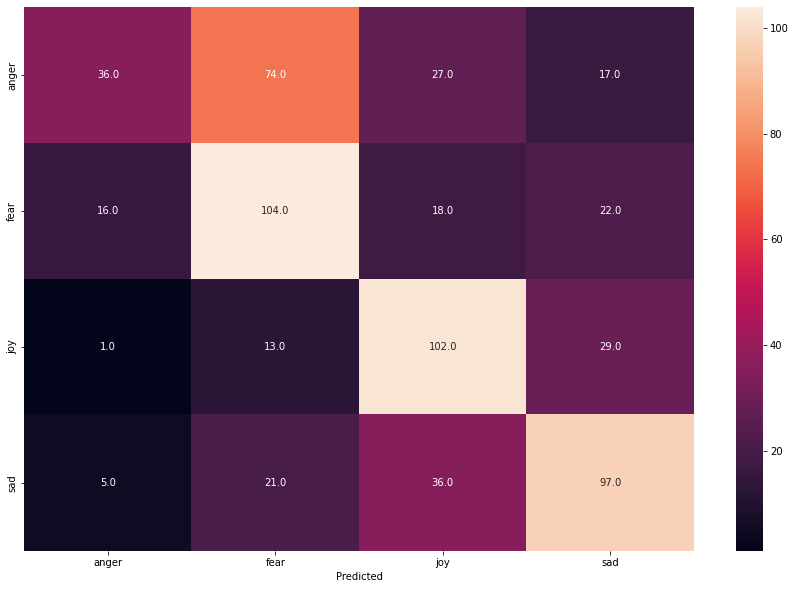

In [ ]:
tars_test_pred = np.array(pred_l)
tars_test_scores = np.array(scores_l)
acc, f1 = classification_report(test_y, labelEncoder.transform(tars_test_pred), labels)
benchmarks_fewshot.append({
    "Model": "TARS (Few Shot)",
    "Accuracy": acc,
    "F1" : f1
})

#Few Shot Summary

In [ ]:
# best_zero_shot = benchmark_df.loc[(benchmark_df.Model=="Huggingface (NLI)") & (benchmark_df.Prompt=="This example is {}"), ["Model", "Accuracy", "F1"]]
best_zero_shot = benchmark_df.iloc[[0, 3, 9]][["Model", "Accuracy", "F1"]]

In [ ]:
benchmarks_fewshot = pd.concat([best_zero_shot, pd.DataFrame(benchmarks_fewshot)])
benchmarks_fewshot

,Model,Accuracy,F1
0,Baseline Supervised,66.828479,66.632344
3,Huggingface (NLI),52.912621,50.770059
9,Domain Adapted Huggingface (NLI),52.427184,52.249640
0,Baseline Supervised (50 Points),46.278317,45.463716
1,Fine-Tuned BERT,45.631068,45.922330
2,TARS (Few Shot),54.854369,52.986977
